In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from flask import Flask, request, jsonify
import pickle

In [35]:
# Load dataset
df = pd.read_excel("Assignment_Data.xlsx")

In [36]:
# Display first few rows
display(df.head())

,CustomerID,Gender,Age,Tenure,MonthlyCharges,TotalCharges,PaymentMethod,Churn,ServiceUsage1,ServiceUsage2,ServiceUsage3
0,CUST0001,Male,20,5,62.31,2950.41,Credit Card,Yes,59,20,63
1,CUST0002,Female,25,23,118.96,7460.55,Bank Transfer,No,42,41,136
2,CUST0003,Female,25,39,69.20,3064.73,Bank Transfer,No,65,0,165
3,CUST0004,Male,56,47,145.90,2612.22,Cash,No,64,40,169
4,CUST0005,Female,33,69,88.51,4833.99,Cash,No,62,1,54


# 1. Exploratory Data Analysis (EDA)


In [37]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 CustomerID        0
Gender            0
Age               0
Tenure            0
MonthlyCharges    0
TotalCharges      0
PaymentMethod     0
Churn             0
ServiceUsage1     0
ServiceUsage2     0
ServiceUsage3     0
dtype: int64


In [38]:
# Data summary
print("\nData Summary:\n", df.describe())



Data Summary:
              Age      Tenure  MonthlyCharges  TotalCharges  ServiceUsage1  \
count  200.00000  200.000000       200.00000    200.000000     200.000000   
mean    42.41000   35.945000        82.97515   5040.986650      50.300000   
std     15.12899   20.311939        37.92233   2802.423841      28.710476   
min     18.00000    1.000000        20.16000    118.080000       0.000000   
25%     29.00000   20.750000        48.72750   2454.822500      25.000000   
50%     42.00000   37.500000        83.59500   4931.905000      51.500000   
75%     55.00000   53.000000       115.75500   7618.195000      76.000000   
max     69.00000   70.000000       149.44000   9984.360000      99.000000   

       ServiceUsage2  ServiceUsage3  
count     200.000000     200.000000  
mean       24.695000     107.100000  
std        14.474791      58.037416  
min         0.000000       2.000000  
25%        13.000000      54.750000  
50%        25.000000     106.500000  
75%        37.000000    

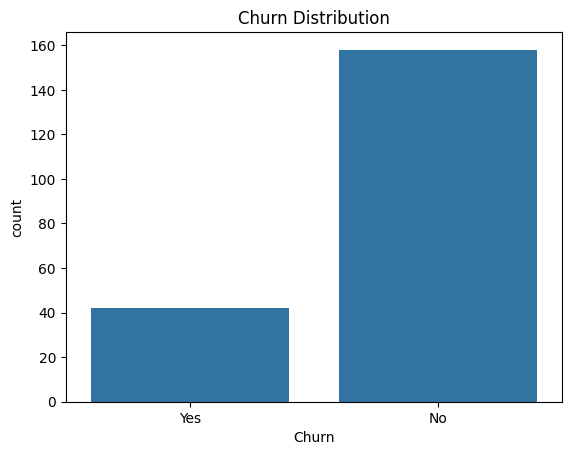

In [39]:
# Churn distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()


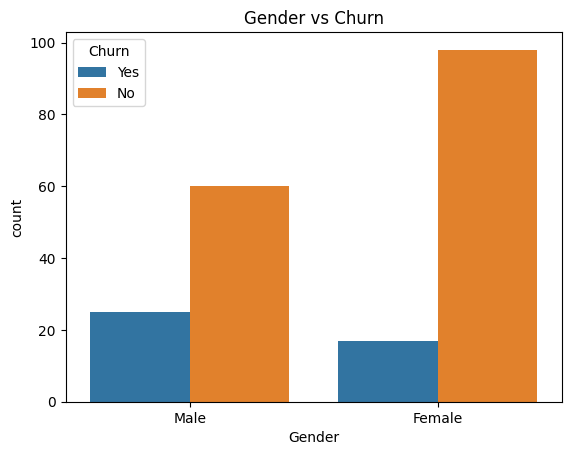

In [40]:
# Gender vs Churn
sns.countplot(x='Gender', hue='Churn', data=df)
plt.title('Gender vs Churn')
plt.show()


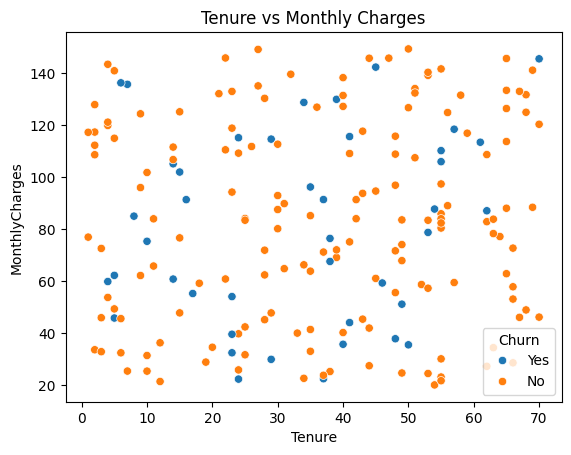

In [41]:
# Tenure vs Monthly Charges
sns.scatterplot(x='Tenure', y='MonthlyCharges', hue='Churn', data=df)
plt.title('Tenure vs Monthly Charges')
plt.show()


# 2. Feature Engineering


In [42]:
# Encode categorical variables
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['PaymentMethod'] = le.fit_transform(df['PaymentMethod'])
df['Churn'] = le.fit_transform(df['Churn'])


In [43]:
# Create new features
df['AvgSpendPerMonth'] = df['TotalCharges'] / df['Tenure']


In [44]:
# Handle potential infinite values from division
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)


In [45]:
# Features and target
X = df.drop(['CustomerID', 'Churn'], axis=1)
y = df['Churn']


In [46]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [48]:
### 3. Handling Class Imbalance with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

C:\Users\RAJGOKUL R M\Documents\ML_SAD\churn_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\RAJGOKUL R M\Documents\ML_SAD\churn_env\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# 3. Predictive Modeling


In [49]:
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced")
}

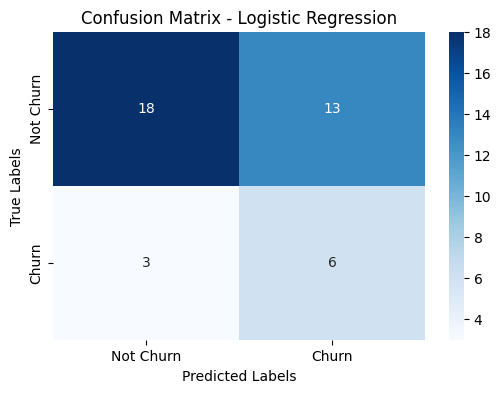

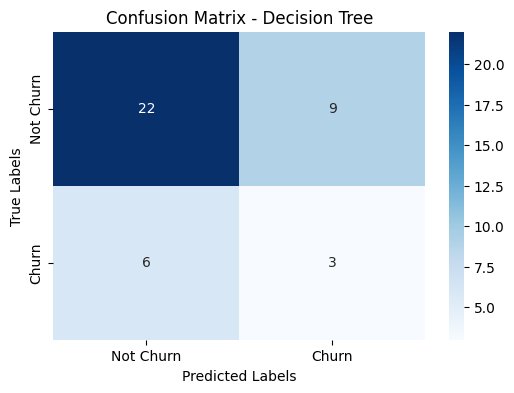

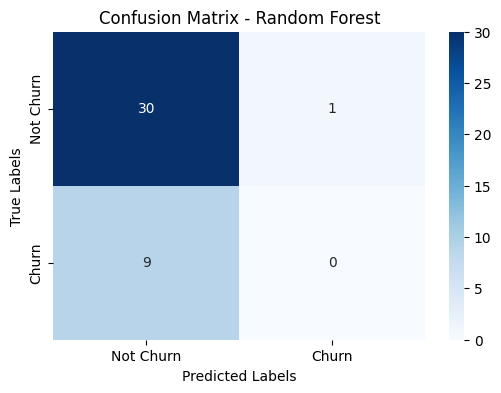

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Train and evaluate models - Visualize Confusion Matrix
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [51]:
# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance:\n", results_df)



Model Performance:
                      Accuracy  Precision    Recall  F1 Score
Logistic Regression     0.600   0.315789  0.666667  0.428571
Decision Tree           0.625   0.250000  0.333333  0.285714
Random Forest           0.775   0.000000  0.000000  0.000000


# 4. Model Interpretation


In [52]:
# Feature importance for Random Forest
best_model = models["Random Forest"]


In [53]:
# Plot feature importances
importances = best_model.feature_importances_
features = X.columns


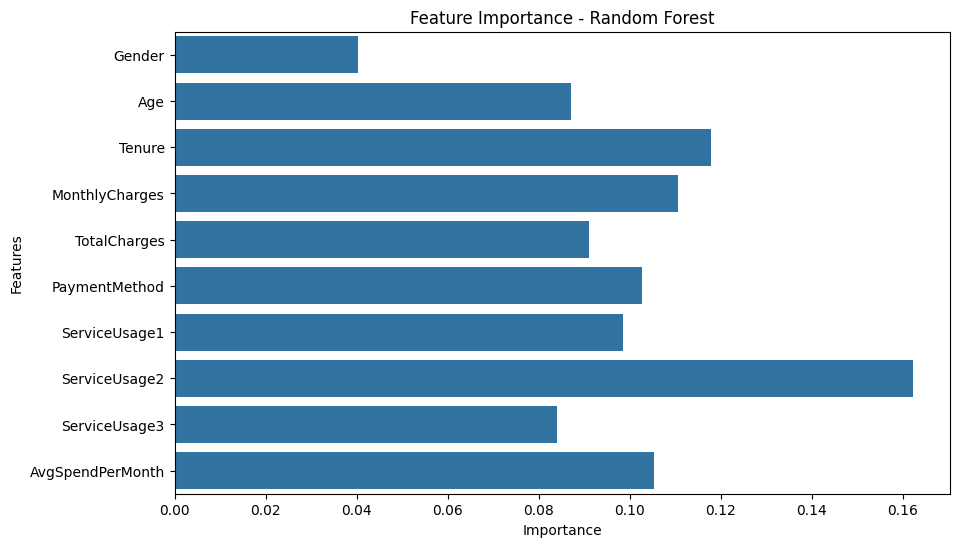

In [54]:

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [55]:
# Identify the top factors contributing to churn
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
print("\nTop Factors Contributing to Churn:\n", importances_df)



Top Factors Contributing to Churn:
             Feature  Importance
7     ServiceUsage2    0.162217
2            Tenure    0.117804
3    MonthlyCharges    0.110546
9  AvgSpendPerMonth    0.105335
5     PaymentMethod    0.102768
6     ServiceUsage1    0.098552
4      TotalCharges    0.091170
1               Age    0.087203
8     ServiceUsage3    0.084121
0            Gender    0.040285


# 5. Recommendation Engine


In [56]:

from sklearn.metrics.pairwise import cosine_similarity

In [57]:
# Create a user-service interaction matrix using ServiceUsage1, ServiceUsage2, and ServiceUsage3
usage_matrix = df[['ServiceUsage1', 'ServiceUsage2', 'ServiceUsage3']].copy()  # Make a copy

# Ensure there are no missing values or infinite values
usage_matrix.replace([np.inf, -np.inf], np.nan, inplace=True)
usage_matrix.fillna(0, inplace=True)

# Display the usage matrix
print("User-Service Interaction Matrix:\n", usage_matrix.head())


User-Service Interaction Matrix:
    ServiceUsage1  ServiceUsage2  ServiceUsage3
0             59             20             63
1             42             41            136
2             65              0            165
3             64             40            169
4             62              1             54


In [58]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between customers
similarity_matrix = cosine_similarity(usage_matrix)

# Display the similarity matrix
print("Cosine Similarity Matrix:\n", similarity_matrix)

Cosine Similarity Matrix:
 [[1.         0.90415171 0.90564866 ... 0.91849993 0.96891437 0.75232522]
 [0.90415171 1.         0.95817466 ... 0.98892154 0.96032245 0.96115454]
 [0.90564866 0.95817466 1.         ... 0.98994521 0.98229082 0.90650582]
 ...
 [0.91849993 0.98892154 0.98994521 ... 1.         0.9835786  0.94033307]
 [0.96891437 0.96032245 0.98229082 ... 0.9835786  1.         0.86455639]
 [0.75232522 0.96115454 0.90650582 ... 0.94033307 0.86455639 1.        ]]


In [59]:
def recommend_services(customer_index, top_n=3):
    # Get the similarity scores for the customer and sort them
    similar_customers = similarity_matrix[customer_index].argsort()[-top_n-1:-1][::-1]
    
    print(f"Top {top_n} similar customers for Customer {df['CustomerID'].iloc[customer_index]}:")

    recommended_services = []
    for i in similar_customers:
        similar_customer_usage = usage_matrix.iloc[i]
        
        # Collect services that the similar customer has used (non-zero usage)
        for j, usage in enumerate(similar_customer_usage):
            if usage > 0 and usage_matrix.iloc[customer_index, j] == 0:  # Check if the target customer has not used this service
                recommended_services.append(usage_matrix.columns[j])
    
    # Return top N unique recommended services
    recommended_services = list(set(recommended_services))[:top_n]
    print("Recommended Services:", recommended_services)
    return recommended_services

# Example: Recommend services for customer at index 0
recommend_services(6)

Top 3 similar customers for Customer CUST0007:
Recommended Services: ['ServiceUsage2']


['ServiceUsage2']

In [60]:
def recommend_for_churning_customer(customer_id):
    # Predict churn using the trained model
    with open("churn_model.pkl", "rb") as f:
        churn_model = pickle.load(f)
    
    customer_data = df[df['CustomerID'] == customer_id].drop(['Churn', 'CustomerID'], axis=1)
    customer_data_scaled = scaler.transform(customer_data)
    
    churn_prediction = churn_model.predict(customer_data_scaled)
    
    if churn_prediction == 1:
        print(f"Customer {customer_id} is likely to churn. Recommending additional services:")
        customer_index = df[df['CustomerID'] == customer_id].index[0]
        recommend_services(customer_index)
    else:
        print(f"Customer {customer_id} is unlikely to churn.")

recommend_for_churning_customer("CUST0007")

Customer CUST0007 is unlikely to churn.


# 6. Deployment Simulation (Flask API)


In [61]:
# Training script to fit and save the scaler

from sklearn.preprocessing import StandardScaler
import pickle

# Assuming you have X_train and y_train from your previous steps
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Save the scaler and model together
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("churn_model.pkl", "wb") as f:
    pickle.dump(best_model, f)  # Use the model you trained (RandomForest, LogisticRegression, etc.)
